In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec

# Julia language is required for SINDy-PI to be able to solve
# the differential algebraic equations (DAEs)
# Note that on my computer, at a terminal, I need to do:
# > julia  (enters the julia console)
# > import Pkg
# > Pkg.add("PyCall")
# > Pkg.add("DiffEqBase")
# > Pkg.add("DifferentialEquations")
# > exit()
# jupyter notebook (startup this notebook)
# Last thing to do (maybe specific to my installation)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

In [2]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')
    
# Plot the objective function vs # iterations
def plot_objective(obj_hist, filename):
    plt.figure(figsize=(6, 6))
    plt.semilogy(obj_hist[1:])
    plt.savefig(filename + '_objective.pdf')

In [3]:
# Define the analytic derivatives for each of the examples in this notebook

# Michaelis–Menten model for enzyme kinetics
def enzyme_deriv(x, t0, jx=0.6, Vmax=1.5, Km=0.3):
    return jx - Vmax * x / (Km + x)


# yeast glycolysis model
def yeast_deriv(x_y_z_t_u_v_w, t0, c1=2.5, c2=-100, c3=13.6769, d1=200, d2=13.6769,
                d3=-6, d4=-6, e1=6, e2=-64, e3=6, e4=16, f1=64, f2=-13, f3=13, f4=-16,
                f5=-100, g1=1.3, g2=-3.1, h1=-200, h2=13.6769, h3=128, h4=-1.28, h5=-32,
                j1=6, j2=-18, j3=-100):
    x, y, z, u, v, w = x_y_z_u_v_w
    return [c1 + c2 * x * v / (1 + c3 * v ** 4), 
            d1 * x * v / (1 + d2 * v ** 4) + d3 * y - d4 * y * w,
            e1 * y + e2 * z + e3 * y * w + e4 *z * v + f5 * t * w, 
            f1 * z + e2 * t + f3 *u + f4 * z * w + f5 * t * w,
            g1 * x + g2 * u, 
            h3 * z + h5 * v + h4 * z * v + h1 * x * v / (1 + h2 * v ** 4), 
            j1 * y + j2 * y * w + j3 * t * w]
    
    
def pendulum_on_cart_deriv(w_x_y_z, t0, m=1, M=1, L1=1, L2=1, F=1, g=9.81):
    w, x, y, z = w_x_y_z
    return [y, z, - ((M + m) * g * np.sin(w) + F * L1 * np.cos(w) + m * L1 ** 2 * np.sin(w) * np.cos(
                w) * y ** 2) / (L1 ** 2 * (M + m - m *np.cos(w) ** 2)),
            m * L1 ** 2 * np.sin(w) * y ** 2 + F * L1 + m * g * np.sin(w) * np.cos(
                w) / (L1 * (M + m - m * np.cos(w)) ** 2)]


def double_pendulum_deriv(w_x_y_z, t0, m1=0.2704, m2=0.2056, a1=0.191, a2=0.1621, L1=0.2667, L2=0.2667, 
                          I1=0.003, I2=0.0011, g=9.81, k1=0, k2=0):
    return [y, z, (L1 * a2 ** 2 * g * m2 ** 2 * np.sin(w) - 2 * L1 * a2 ** 3 * z **2 * m2 **2 * np.sin(
                w - x) + 2 * I2 * L1 * g * m2 * np.sin(w) + L1 * a2 **2 * g * m2 **2 *np.sin(
                w - 2 * x) + 2 * I2 * a1 * g * m1 * np.sin(w) - (L1 * a2 * y * m2) ** 2 * np.sin(
                2 * (w - x)) - 2 * I2 * L1 * a2 * z ** 2 * m2 * np.sin(
                w - x) + 2 * a1 * a2 ** 2 * g * m1 * m2 * np.sin(w)) / (2 * I1 * I2 + (L1 * a2 * m2
                ) ** 2 + 2 * I2 * L1 ** 2 * m2 + 2 * I2 * a1 ** 2 * m1 + 2 * I1 * a2 ** 2 * m2 - (
                L1 * a2 * m2) ** 2 * np.cos(2 * (w - x)) + 2 * (a1 * a2) ** 2 * m1 * m2), 
                (a2 * m2 * (2 * I1 * g * np.sin(
                x) + 2 * L1 ** 3 * y ** 2 * m2 * np.sin(w - x) + 2* L1 ** 2 * g * m2 * np.sin(x) + 2* I1 * L1 * y **2 * np.sin(
                w - x) + 2* a1 ** 2 * g * m1 * np.sin(x) + L1 ** 2 * a2 * z ** 2 * m2 * np.sin(
                 * (w - x)) + 2 * L1 * a1 ** 2 * y ** 2 * m1 * np.sin(w - x) - 2 * L1 ** 2 * g * m2 * np.cos(
                w - x) * np.sin(w) - 2 * L1 * a1 * g * m1 * np.cos(w - x) * np.sin(w))) / ( 2 * (
                I1 * I2 + (L1 * a2 * m2) ** 2 + I2 * L1 ** 2 * m2 + I2 * a1 ** 2 * m1 + I1 * a2 ** 2 * m2 - (L1 * a2 * m2) ** 2 * np.cos(
                w - x) ** 2 + a1 ** 2 * a2 ** 2 * m1 * m2))]


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ np.transpose(full_coefficients), axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [33]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0 = np.random.rand(r) - 0.5
x_train = integrate.odeint(enzyme_deriv, x0, t)
x0 = np.random.rand(r)
x_test = integrate.odeint(enzyme_deriv, x0, t)

# define hyperparameters
threshold = 1e-2

fd = FiniteDifference(drop_endpoints=False)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t)) # * dt)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t)) # * dt)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3]
                     #lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                     #lambda x, y:x * y ** 3, lambda x:x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x] #, lambda x, y: x * y, lambda x:x ** 2]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x:'', lambda x:x] 
                          #lambda x, y: x + y, lambda x: x + x]
# print(library_function_names)
print(np.shape(library_function_names))
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# max_iter = 10000 by default here because cvxpy is doing all the work
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(9,)
(499, 1)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4120, constraints m = 4128
          nnz(P) + nnz(A) = 40184
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 20000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -7.0200e-02   1.00e+00   3.64e+04   1.00e-01   4.31e-03s
 200   2.2236e-01   2.49e-03   4.34e-06   2.09e-03   2.43e-02s
 400   2.2235e-01   4.27e-0

SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7f33482cd190>,
      feature_names=['x0'],
      optimizer=SINDyPIoptimizer(max_iter=20000, threshold=0.01))

['', 'xdot0', 'x0', 'x0xdot0', 'x0x0', 'x0x0xdot0', 'x0x0x0', 'x0x0x0xdot0']
[[ 9.35973861e-15  5.94228639e-01  1.99302298e-01  1.23839572e-01
  -3.81540400e-03  4.38481607e-04 -2.19507364e-11  6.99171029e-05]
 [ 1.67005313e+00  1.68822929e-16 -3.36376775e-01 -1.98450107e-01
   1.12588890e-13  1.87125405e-03 -3.06207890e-03 -3.93876921e-08]
 [ 5.00258804e+00 -2.97373086e+00 -8.37469485e-16 -6.14822195e-01
   2.14901627e-01 -2.69169316e-13  3.72616566e-02 -1.38750287e-07]
 [ 5.34851631e+00 -3.05140040e+00 -8.88519909e-01  1.66728053e-18
  -1.87712809e-01  2.73462709e-14 -6.70688635e-13 -5.88933674e-08]
 [ 1.14942027e-14 -6.92425302e-15 -1.94563712e-14 -4.86518450e-16
   1.00219248e-15 -6.72505037e-14 -3.60097427e-13 -2.15791426e-09]
 [-6.53543989e-16  1.01664346e-15 -3.01566034e-15  1.18752597e-16
  -8.02500667e-14  9.81618550e-18 -6.23517948e-14 -5.36960214e-09]
 [-6.51587725e-15 -2.36447895e-15 -1.19409003e-14 -3.41492470e-17
   1.47877619e-13 -1.56147678e-14 -7.86776675e-17  2.196797

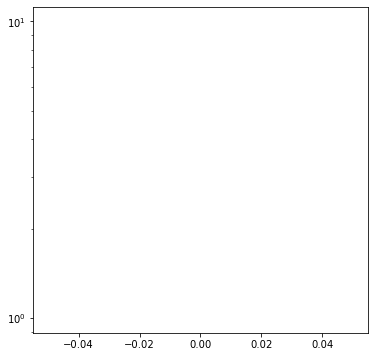

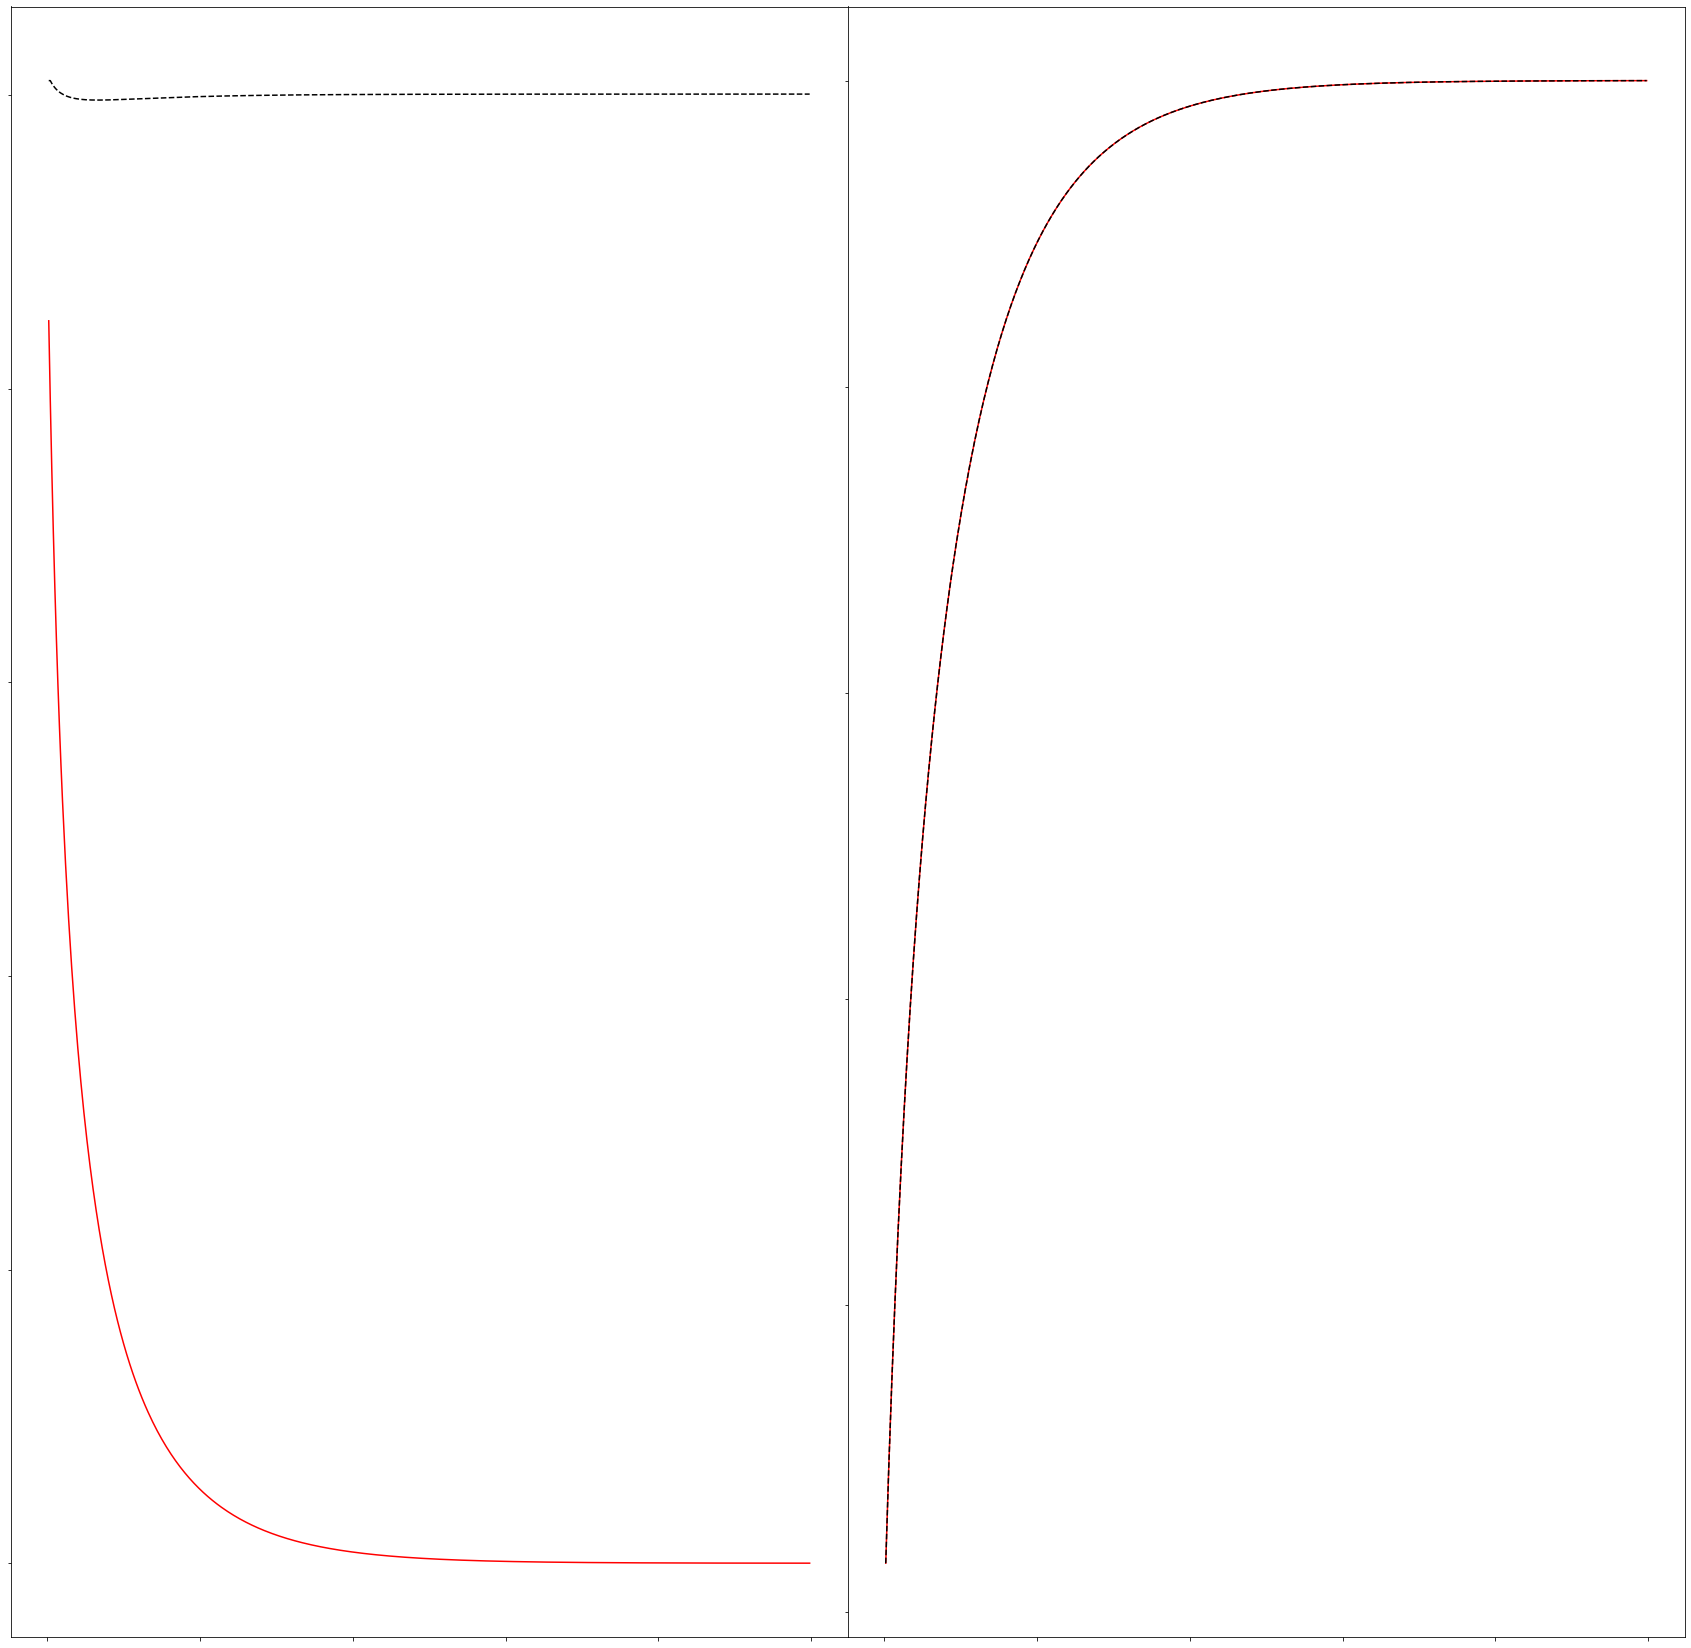

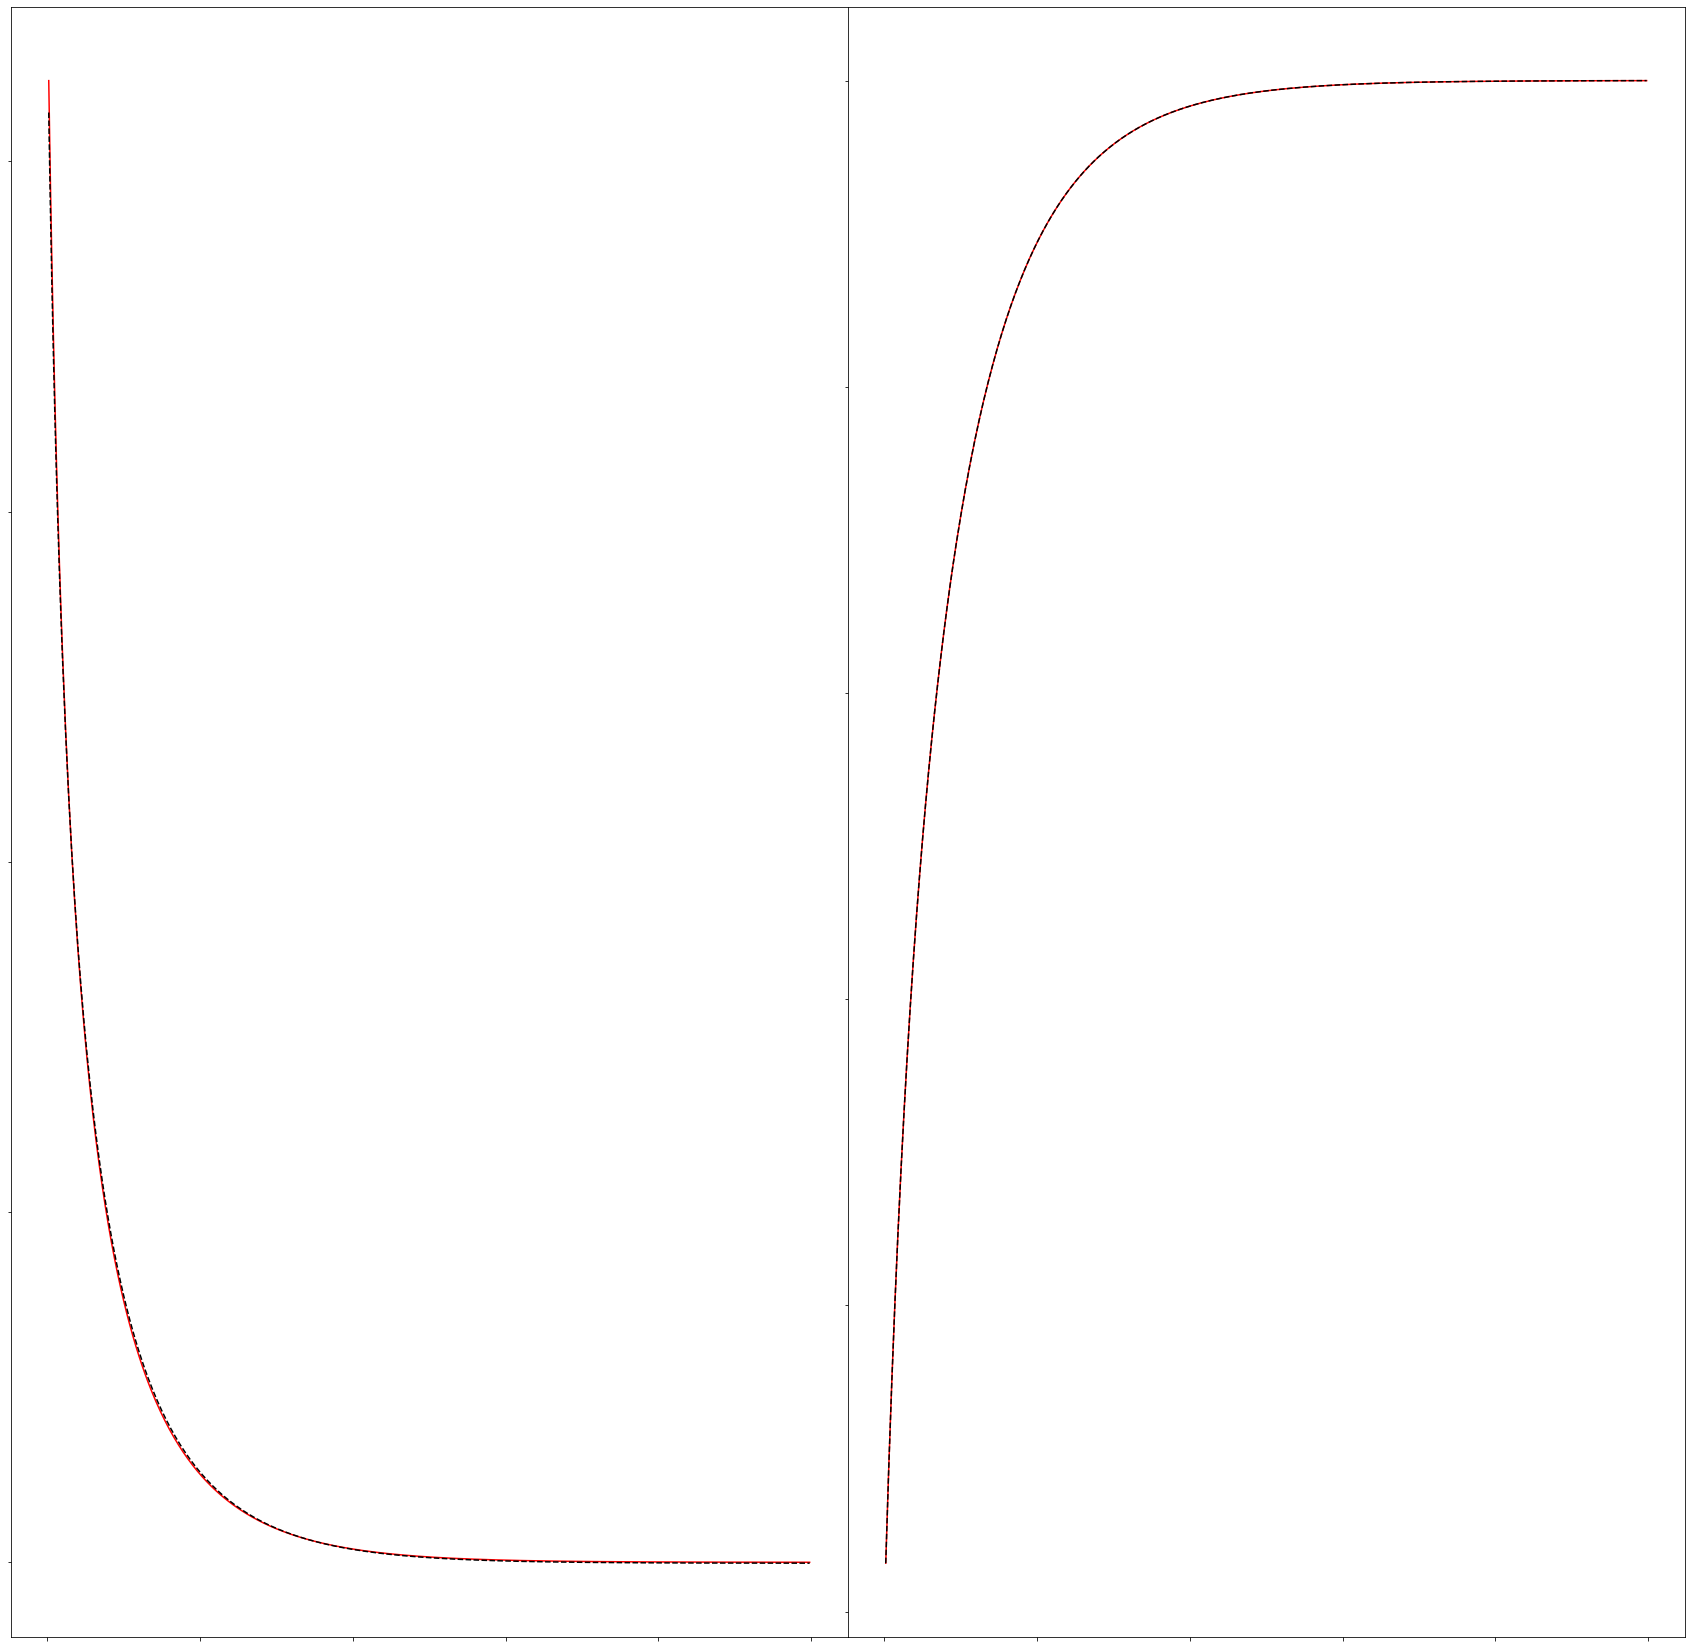

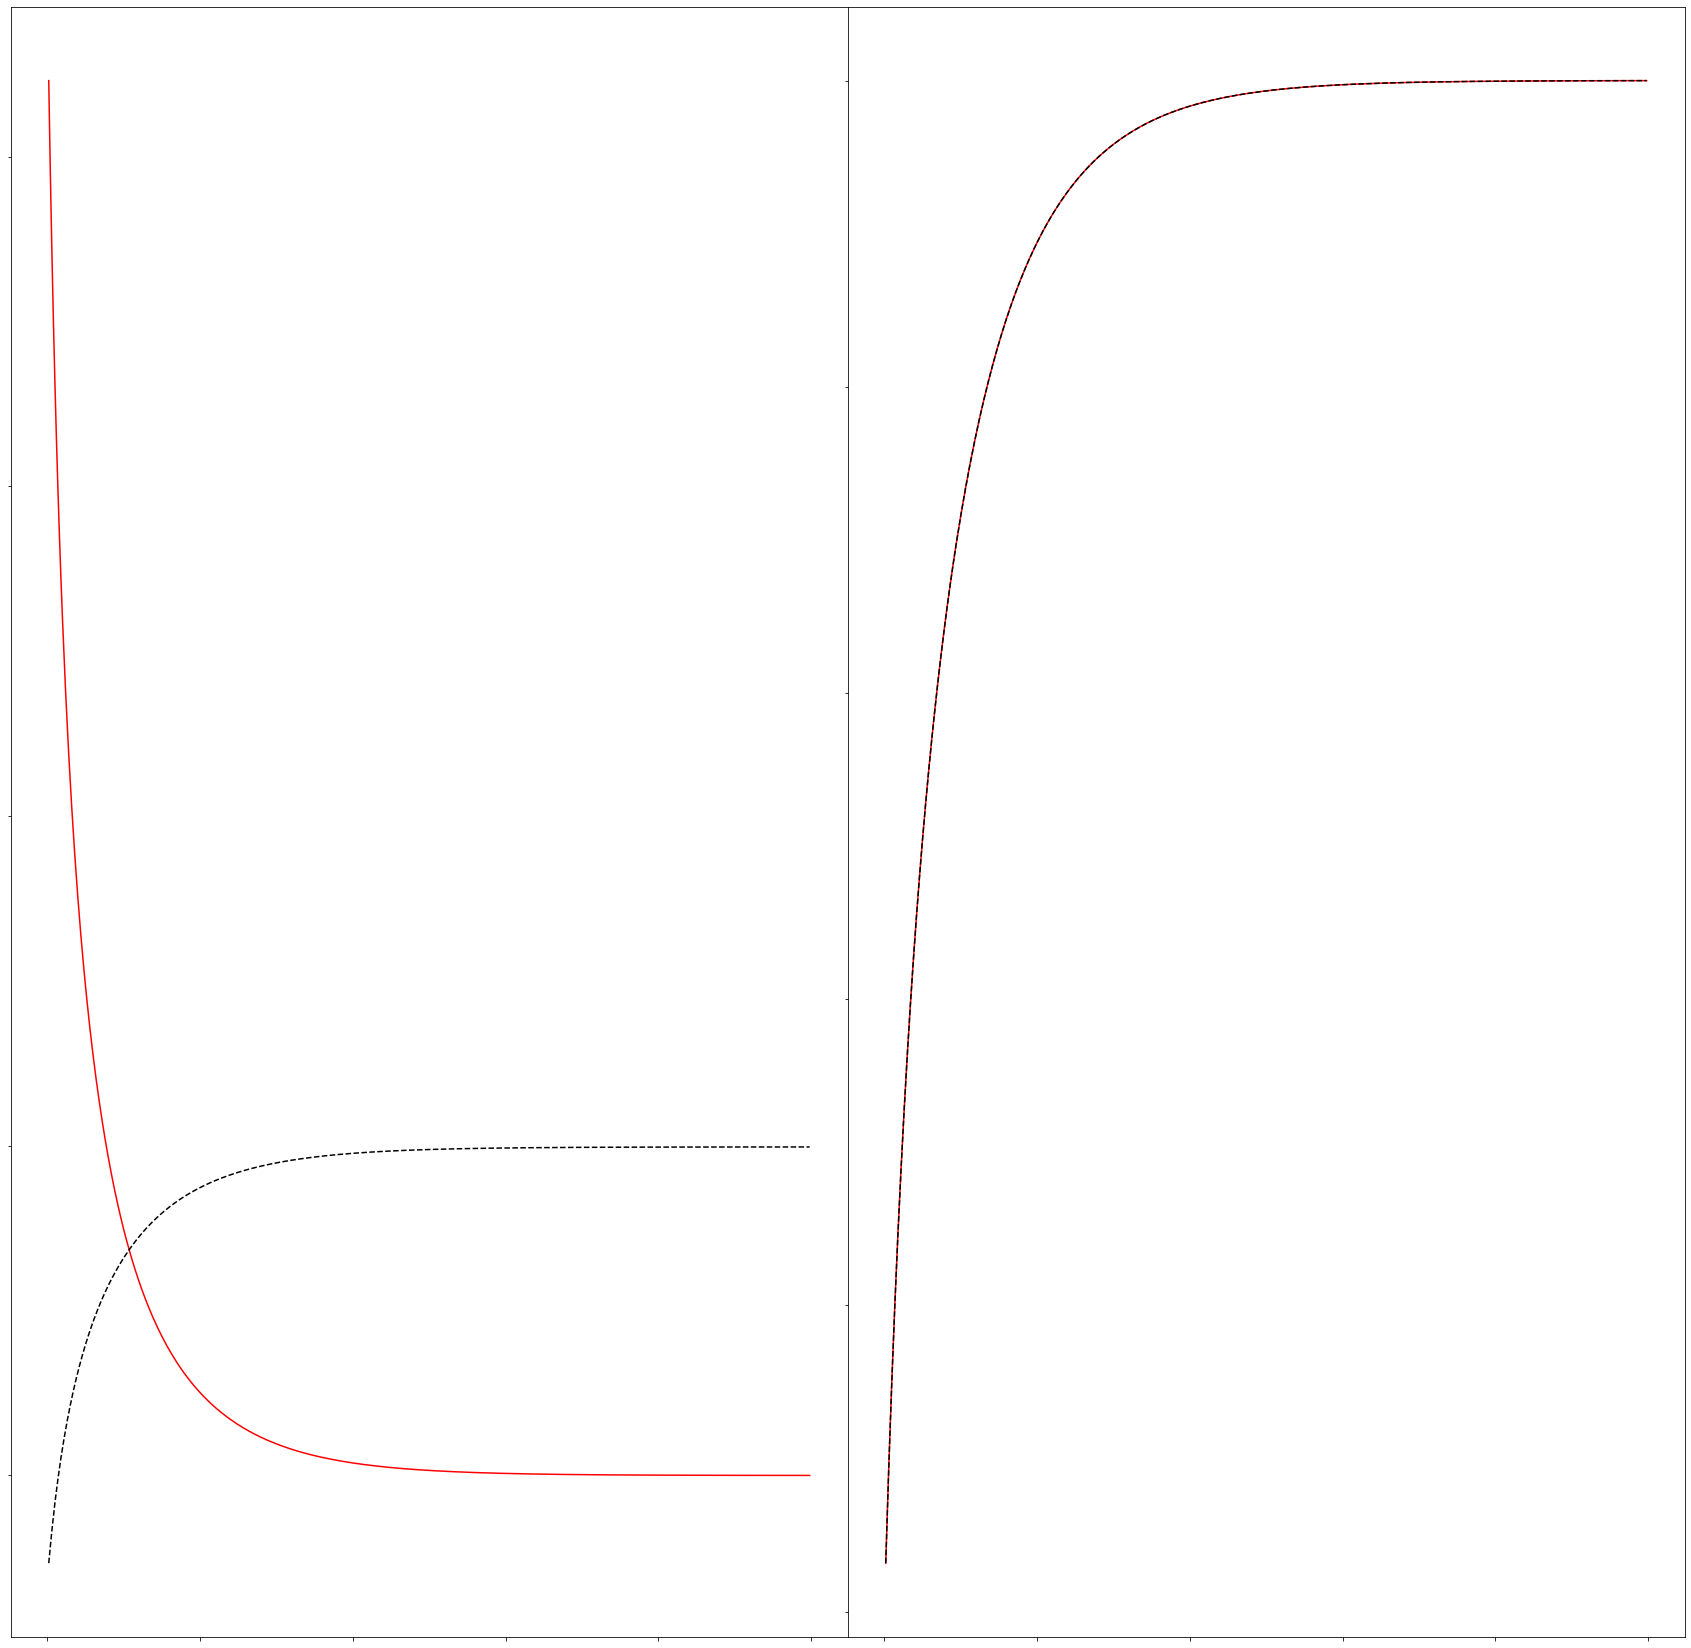

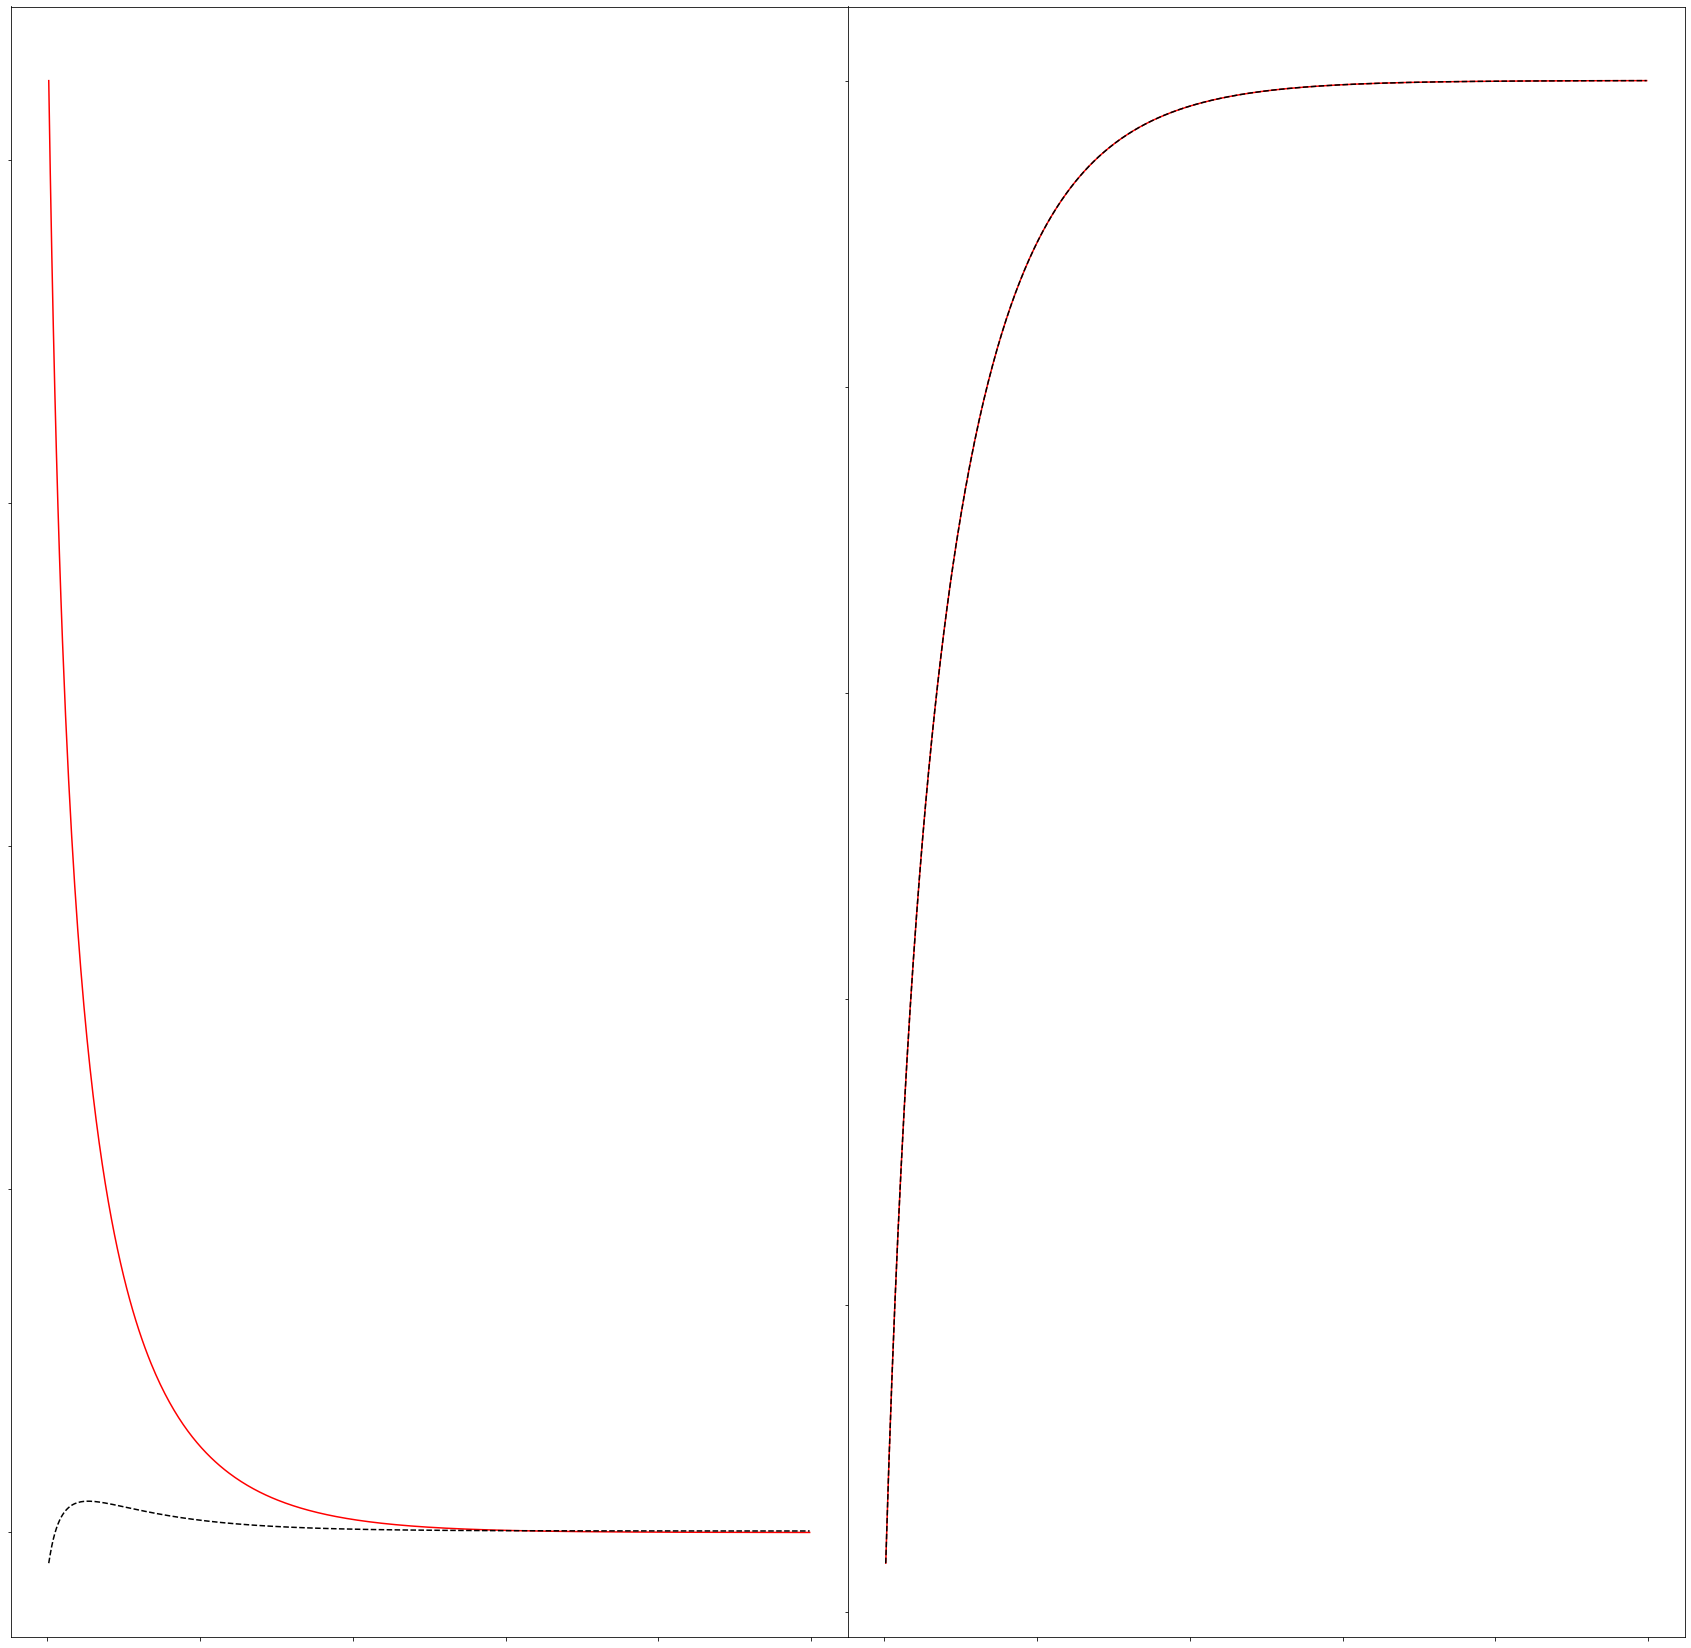

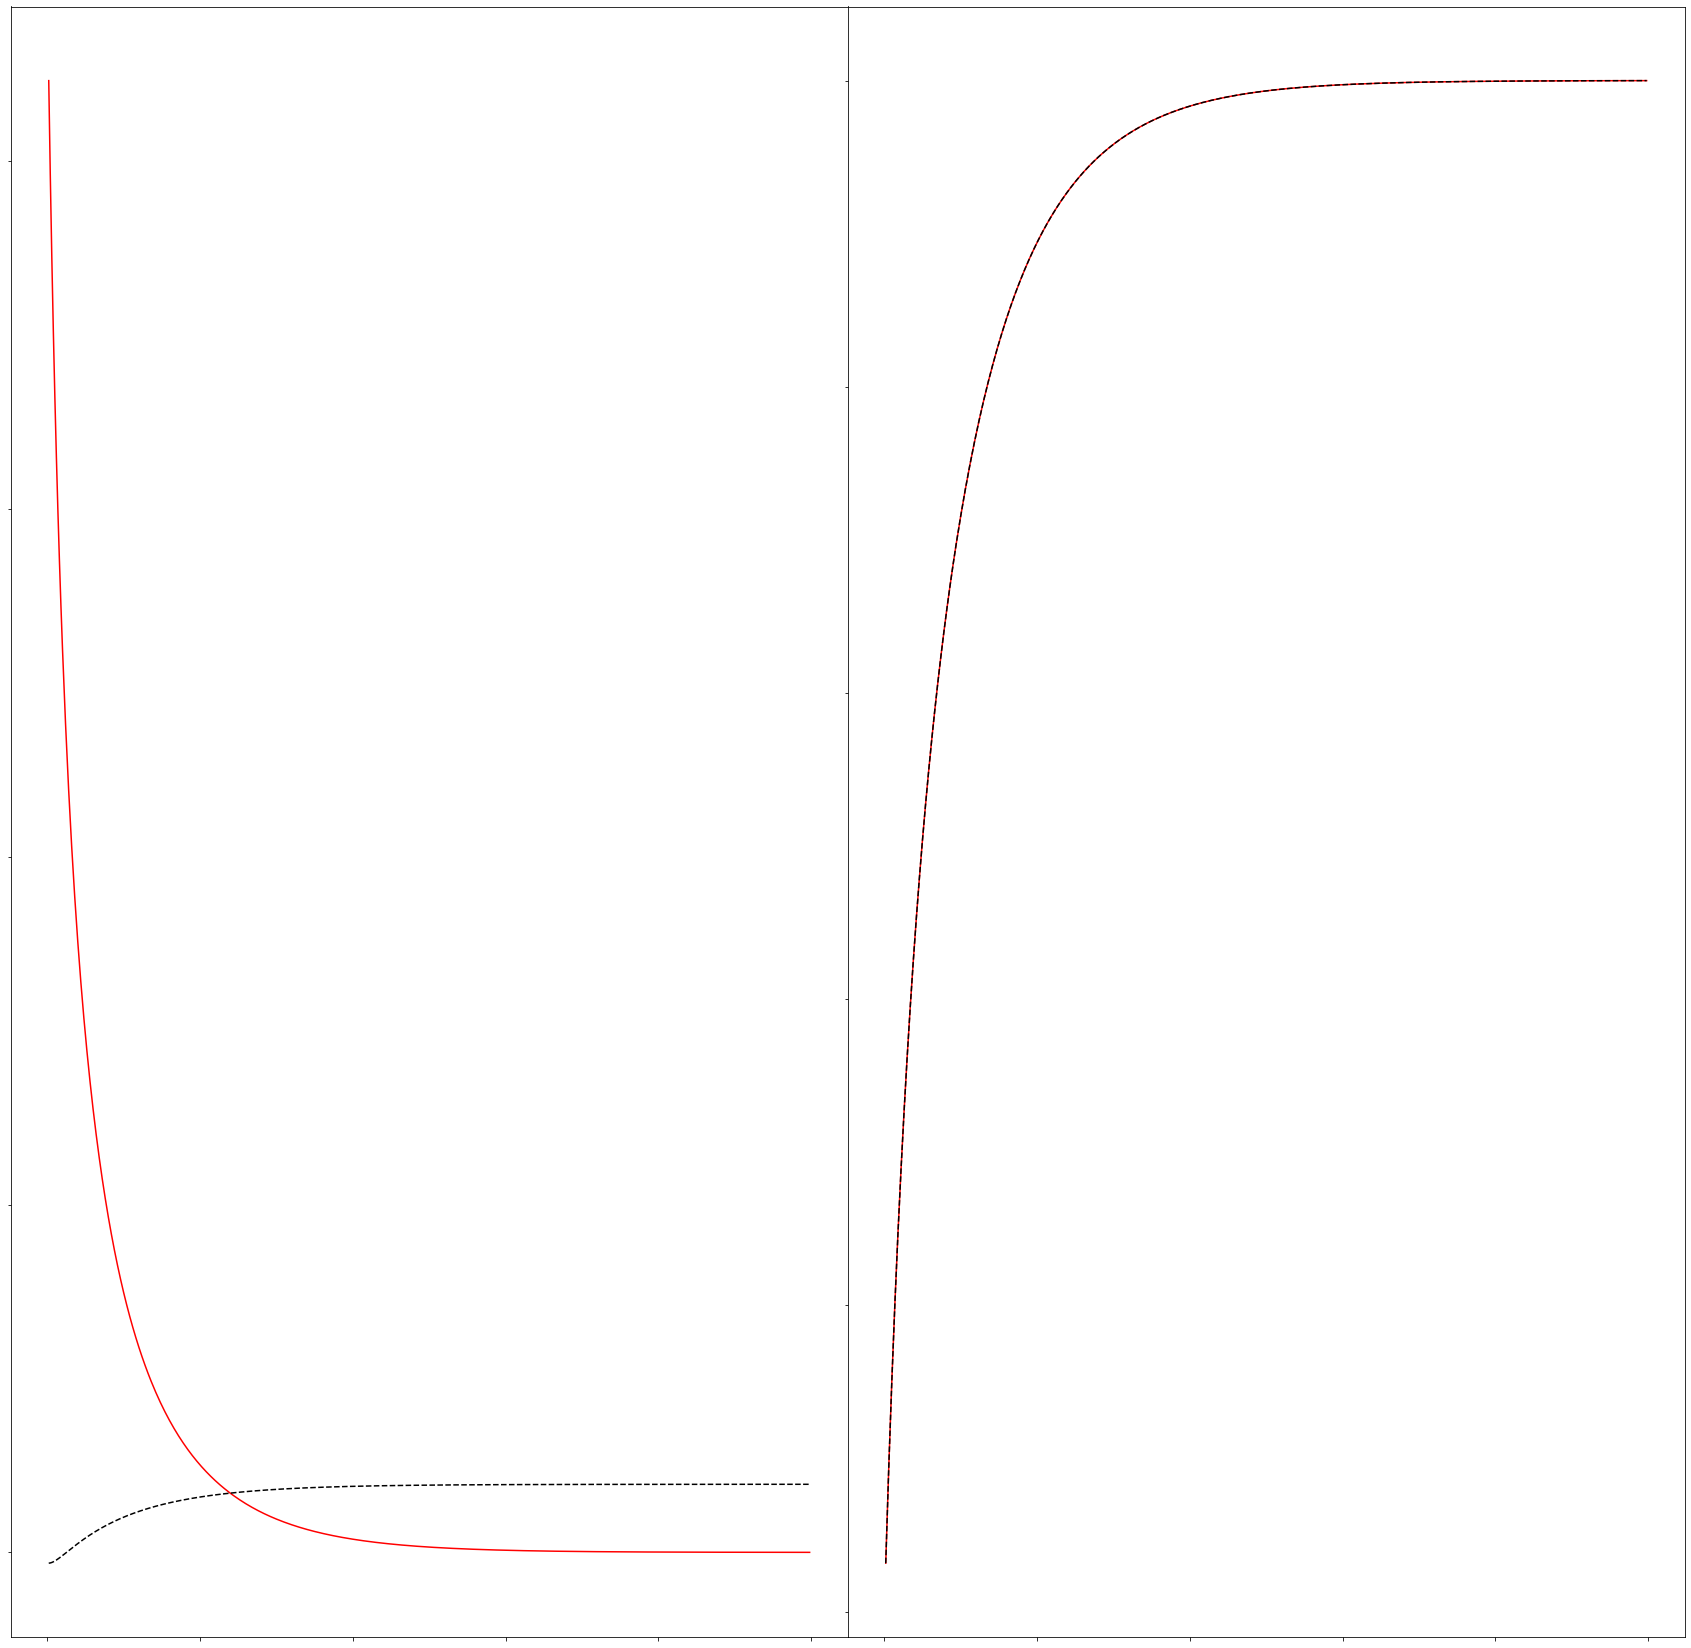

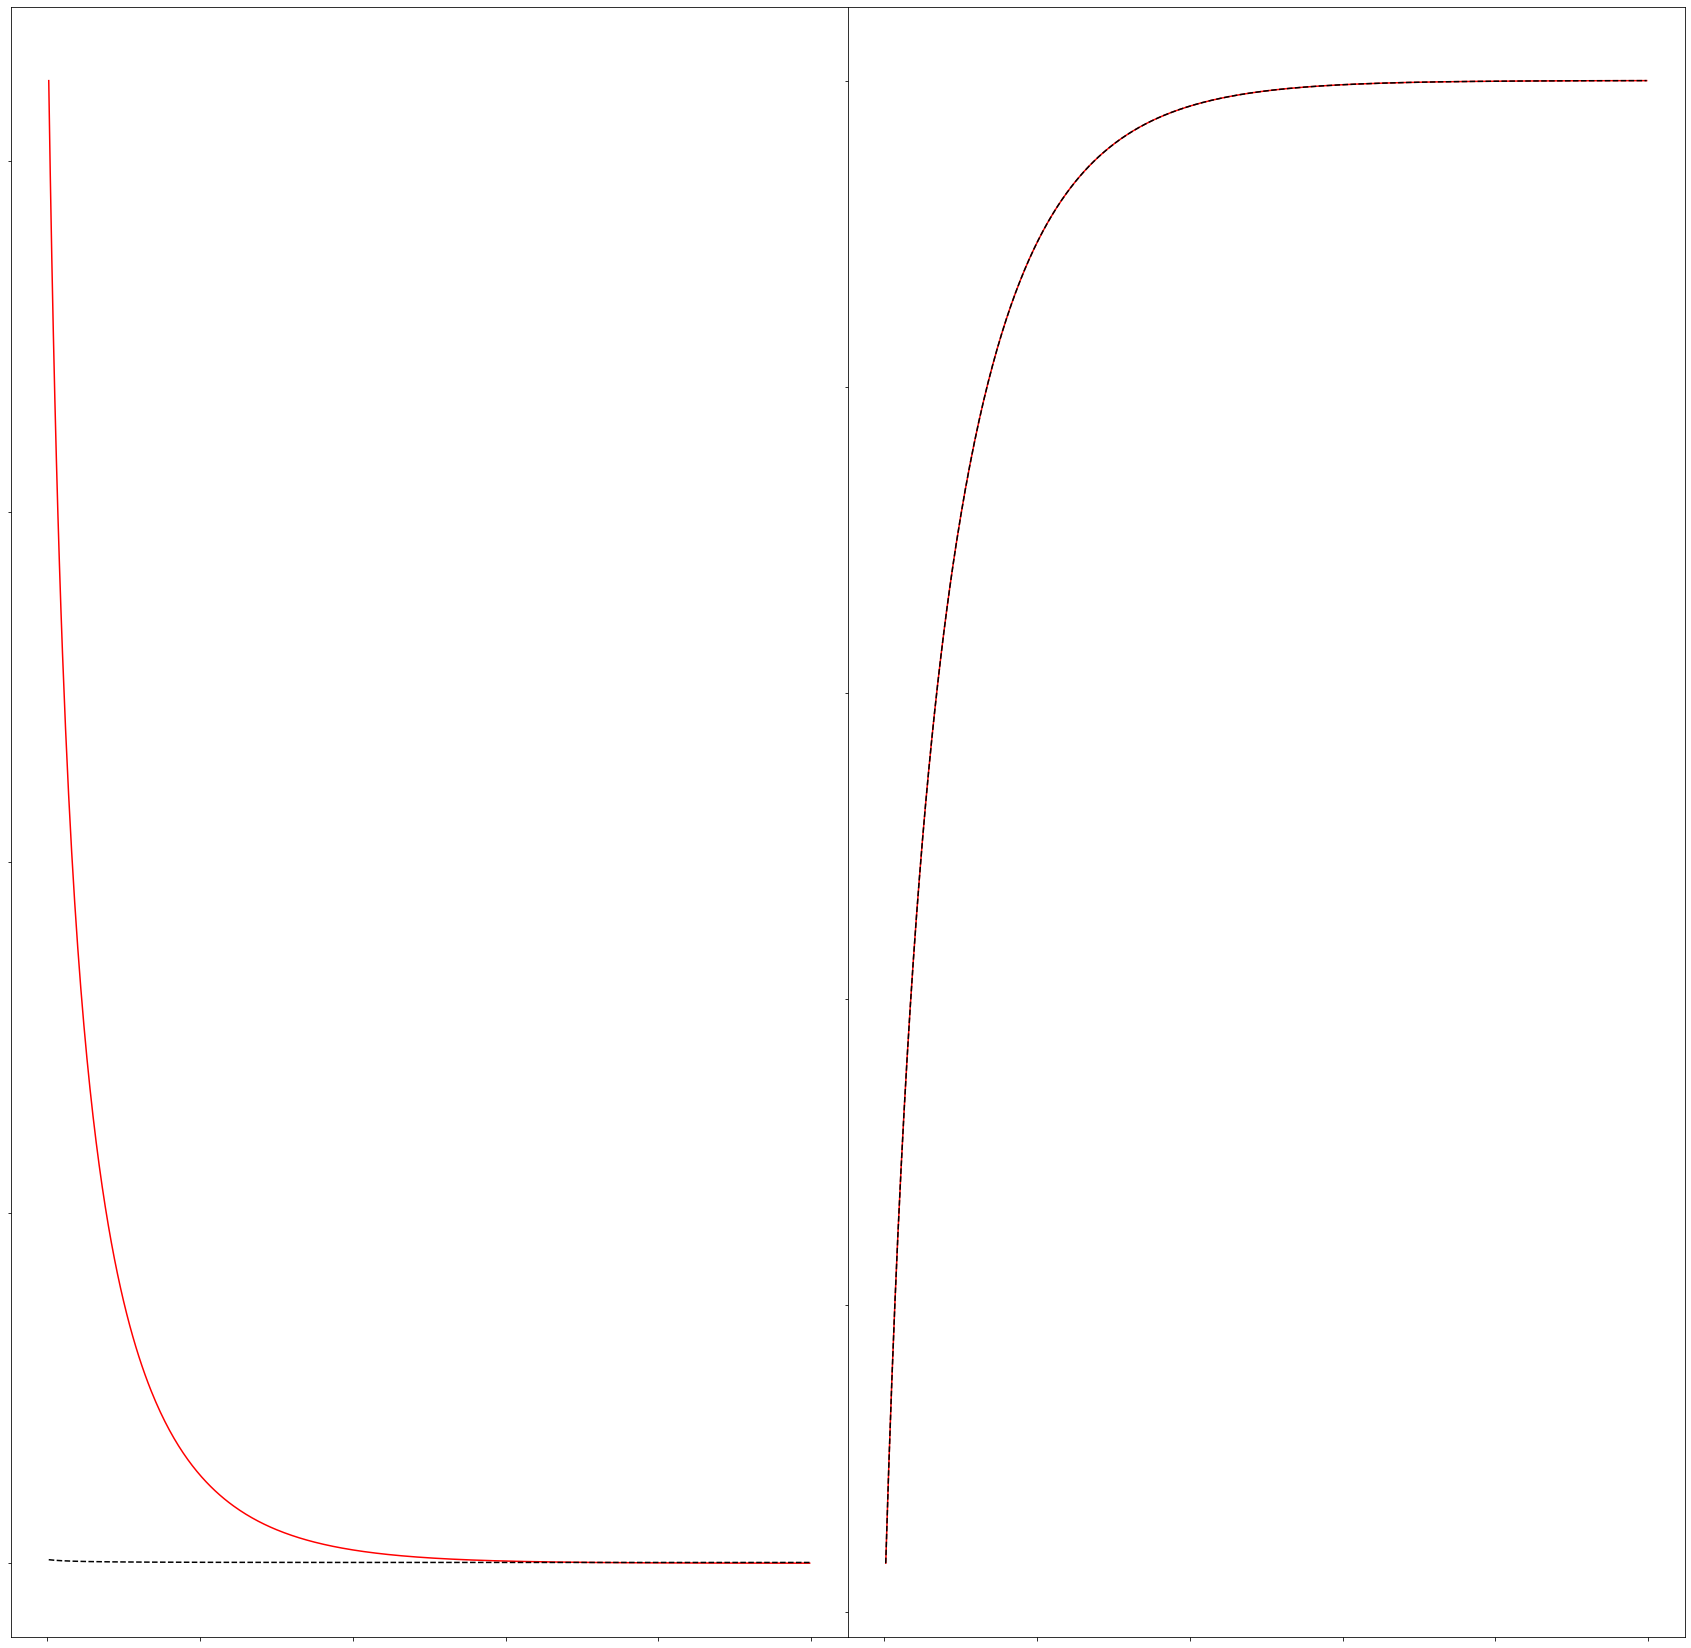

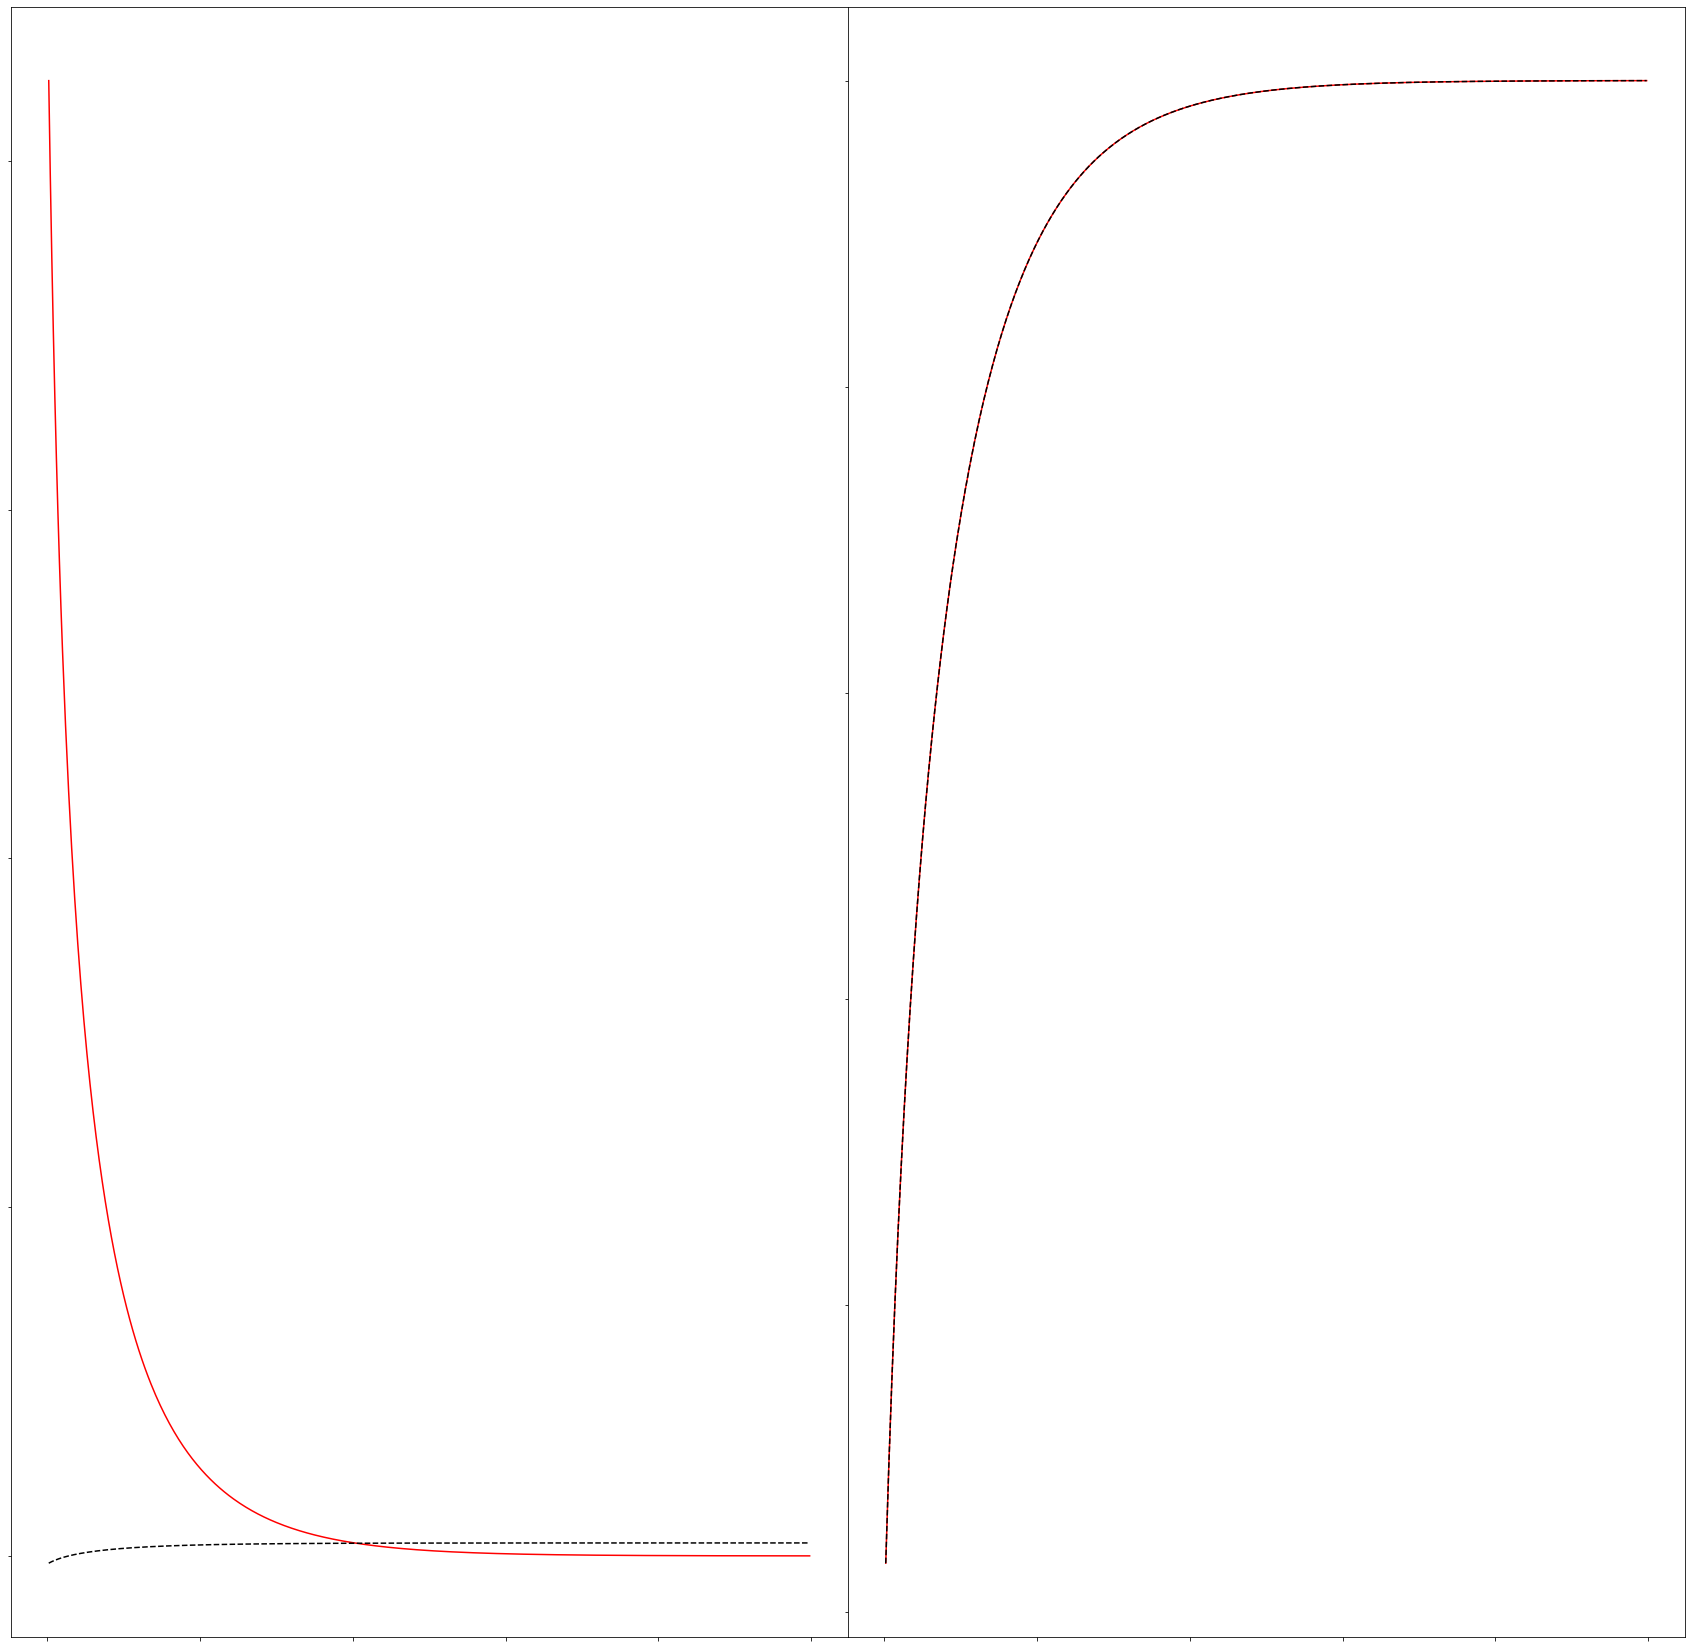

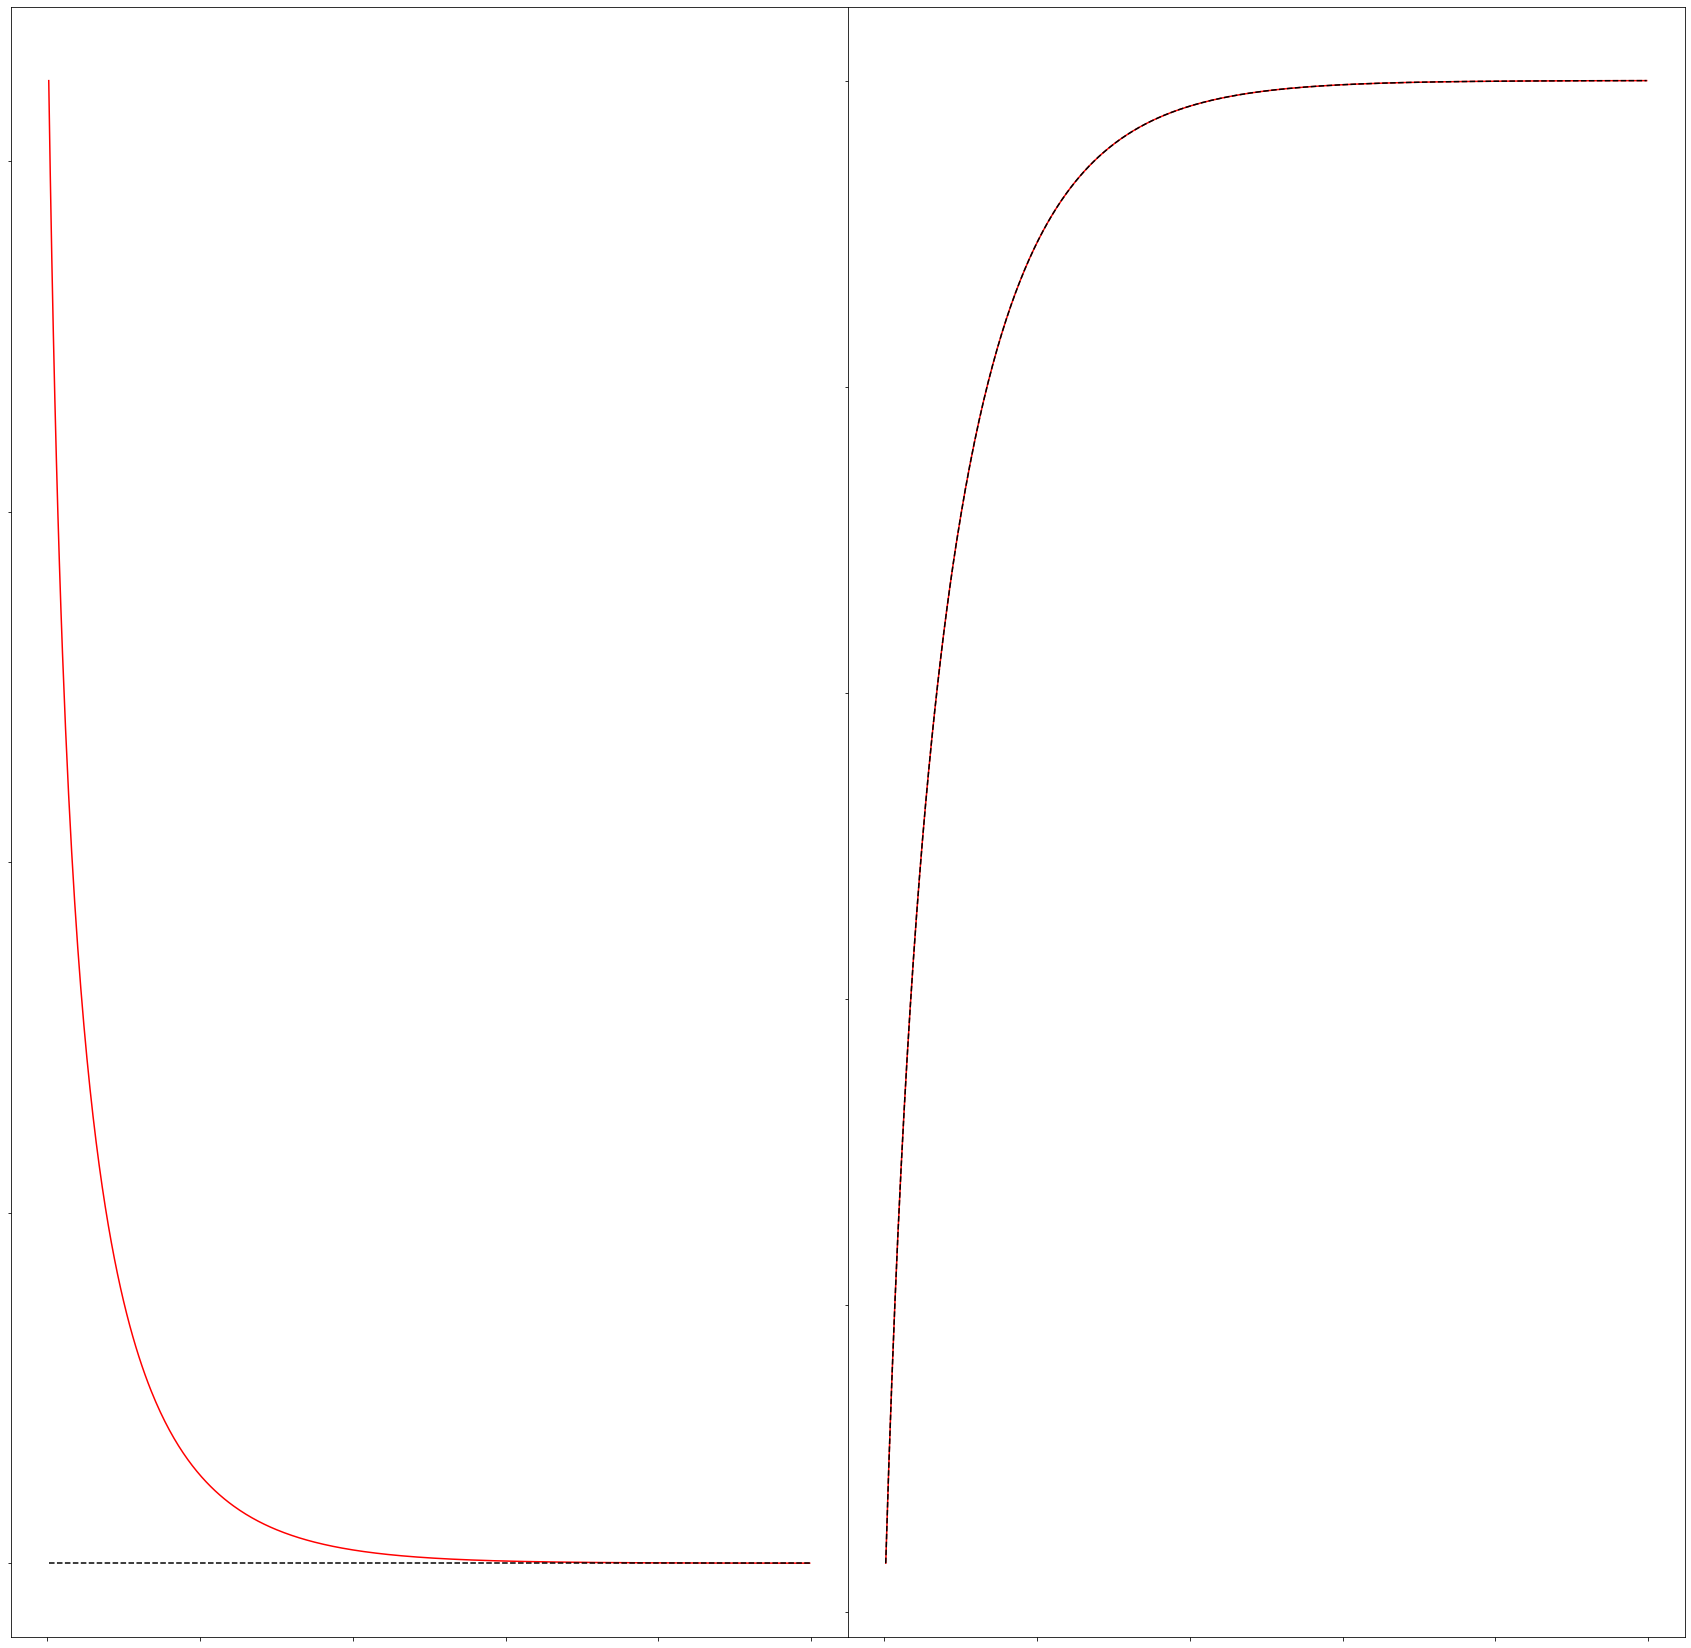

In [34]:
print(model.get_feature_names())
#model.print()
# Don't do this in SINDy-PI... "Xi = model.coefficients().T"
# Do this instead >
print(np.transpose(sindy_opt.coef_))
plot_objective(sindy_opt.objective_history, 'Michaelis–Menten')
xdot_test = model.differentiate(x_test, t=t)
#xdot_test_pred = model.predict(x_test)
print(model_error(xdot_train, sindy_opt.Theta, sindy_opt.coef_))

for i in range(np.shape(sindy_opt.coef_)[1]):
    xdot_test_pred = np.reshape((sindy_opt.Theta @ np.transpose(sindy_opt.coef_)[:, i]), (np.shape(sindy_opt.Theta)[0], 1))
    make_fits(r, t[1:-1], xdot_train[1:-1], xdot_test_pred, x_train[1:-1], x_train[1:-1], "Michaelis–Menten")
    print(prediction_error(xdot_train[1:-1], xdot_test_pred))
# x_train_pred = model.simulate(x_train[0, :], t)
# x_test_pred = model.simulate(x_test[0, :], t)

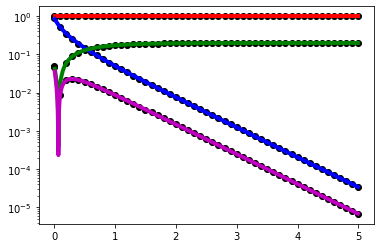

In [35]:
colors = ['r', 'b', 'g', 'm']
plt.semilogy(t[::10], np.ones(len(t[::10])), 'ko')
plt.semilogy(t[::10], np.abs(x_train[::10]), 'ko')
plt.plot(t[::10], np.abs(x_train[::10] * xdot_train[::10]), 'ko')
plt.semilogy(t[::10], np.abs(xdot_train[::10]), 'ko')
for i in range(4):
    plt.plot(t[1:-1], np.abs(sindy_opt.Theta[:, i]), colors[i], linewidth=4)

## The problem here is that Theta(X, Xdot) is still using the training data... it needs to use the testing data
## to correctly get Xdot. 

['', 'xdot0', 'x0', 'x0xdot0', 'x0x0', 'x0x0xdot0', 'x0x0x0', 'x0x0x0xdot0']
['1', 'du[0]', 'u[0]', 'u[0]*du[0]', 'u[0]*u[0]', 'u[0]*u[0]*du[0]', 'u[0]*u[0]*u[0]', 'u[0]*u[0]*u[0]*du[0]']
1 0.5942286392116543
du[0] 1.6882292945072938e-16
u[0] -2.973730860217203
u[0]*du[0] -3.051400397108334
u[0]*u[0] -6.9242530206551986e-15
u[0]*u[0]*du[0] 1.0166434589765205e-15
u[0]*u[0]*u[0] -2.364478945092967e-15
u[0]*u[0]*u[0]*du[0] -6.863280518623103e-17
coef[0] * eval(feature_names[0]) + coef[1] * eval(feature_names[1]) + coef[2] * eval(feature_names[2]) + coef[3] * eval(feature_names[3]) + coef[4] * eval(feature_names[4]) + coef[5] * eval(feature_names[5]) + coef[6] * eval(feature_names[6]) + coef[7] * eval(feature_names[7]) - du


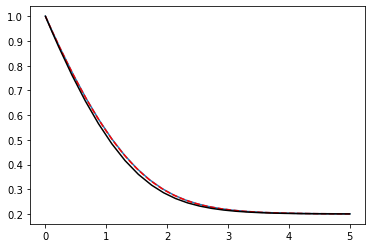

In [39]:
def f(du,u,p,t):
    resid = 3.0/5.0 - 3.0 * u - 10.0 / 3.0 * u * du - du
    return resid

coef = np.transpose(sindy_opt.coef_)[:, 1]
feature_names = model.get_feature_names()
print(feature_names)
for i in range(len(feature_names)):
    if feature_names[i] == '':
        feature_names[i] = '1'
    for j in range(r):
        feature_names[i] = feature_names[i].replace("xdot" + str(j), "du[" + str(j) + "]*")  
        feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
    if feature_names[i][-1] == '*':
        feature_names[i] = feature_names[i][:-1]
print(feature_names)
eval_string = ''
for i in range(len(feature_names)):
    eval_string += 'coef[' + str(i) + '] * eval(feature_names[' + str(i) + '])'
    if i != len(feature_names) - 1:
        eval_string += ' + '
    else:
        eval_string += ' - du'
    print(feature_names[i], coef[i])
print(eval_string)

def h(du, u, p, t):
    resid = float(eval(eval_string))
    return resid

u0 = [1.0]
du0 = [-0.04]
tspan = (0.0,5.0)
differential_vars = [True]
prob = de.DAEProblem(f,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
plt.plot(sol.t, sol.u)
plt.plot(t, integrate.odeint(enzyme_deriv, u0[0], t), 'r--')

prob = de.DAEProblem(h,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k')


In [37]:
# Okay, so need some way to convert the SINDy coefficients and model directly into a implicit ODE
# that can solved by diffeqpy